<a href="https://colab.research.google.com/github/abdulSalamKagaji97/data_690_deeplearning/blob/main/DATA690_FINAL_PROJECT_ABDUL_SALAM_KAGAJI_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import zipfile
from google.colab import drive
import os

drive.mount('/content/drive/')

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/data_690_deeplearning_project3_dataset/ECG_img_data.zip", 'r')
zip_ref.extractall("/content/")
zip_ref.close()

Mounted at /content/drive/


In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from PIL import Image
from timeit import default_timer as timer

import torchvision
from torchvision import transforms, datasets, models

import torch
from torch import optim, cuda
from torch.utils.data import DataLoader, sampler
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F

from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d
from torch.nn import Module, Softmax, BatchNorm2d, Dropout

import gc
import os
from os import walk
import glob
import cv2
from sklearn.metrics import confusion_matrix

from IPython.core.interactiveshell import InteractiveShell
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
InteractiveShell.ast_node_interactivity = 'all'

In [3]:
data_path = "/content/ECG_Image_data"
print(os.listdir(data_path))

['test', 'train']


In [5]:
classes = ('S', 'V', 'Q', 'N', 'F')

In [4]:
# create data transformers and train data loaders
train_data_path        = data_path+'/train'
transform         = transforms.Compose(
                                       [transforms.Resize([120,120]), # resizing the image
                                        transforms.Grayscale(),  # converting image to single gray channel
                                        transforms.ToTensor(), # transforming image to a tensor
                                        transforms.Normalize((0.5), (0.5)) # normalizing the tensor
                                       ])
  
train_data_set    = datasets.ImageFolder(root=train_data_path, transform=transform)
batch_size=32
train_data_loader = DataLoader(train_data_set, batch_size=batch_size, shuffle=True)

In [5]:
# crating test data loaders
test_data_path        = data_path+'/test'
test_data_set    = datasets.ImageFolder(root=test_data_path, transform=transform)
test_data_loader = DataLoader(test_data_set, batch_size=batch_size, shuffle=True)

In [6]:
# CNN model

class Convnet(nn.Module):
    
    def __init__(self):
        
        super(Convnet, self).__init__()

        self.layer_1  = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1)
        
        self.relu1    = nn.ReLU(inplace=True)
        
        self.maxpool1 = MaxPool2d(kernel_size=2)
        

        self.layer_2  = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1)
        
        self.relu2    = nn.ReLU(inplace=True)


        self.layer_3  = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        
        self.relu3    = nn.ReLU(inplace=True)

        
        self.drop_out = nn.Dropout()
        
        
        # out_channels = 4, number of classes = 5
        
        # image width = 120, image height = 120 after two maxpooling 120 -> 60 -> 30
        
        self.fc1 = nn.Linear(32 * 60 * 60, 5)
        
    # Defining the forward pass

    def forward(self, x):
        
        out = self.layer_1(x)
        
        out = self.relu1(out)
        
        out = self.maxpool1(out)
        
        
        out = self.layer_2(out)
        
        out = self.relu2(out)
        
        # out = self.maxpool2(out)

        out = self.layer_3(out)
        
        out = self.relu3(out)
        
        # out = self.maxpool3(out)
        
        
        out = out.reshape(out.size(0), -1)
        
        out = self.drop_out(out)
        
        out = self.fc1(out)
        
        return out
    
# Define Model

model = Convnet()

print(model)

Convnet(
  (layer_1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU(inplace=True)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layer_2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU(inplace=True)
  (layer_3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU(inplace=True)
  (drop_out): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=115200, out_features=5, bias=True)
)


In [7]:
# Define Criterion

criterion = nn.CrossEntropyLoss()

# Define Optimizer

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [8]:
# Whether to train on a gpu and Number of gpus

if cuda.is_available(): 
    
    print(f'{cuda.device_count()} number of gpus are detected and available.')
    
else:
        
    print(f'Train on gpu is not available')
        
        

1 number of gpus are detected and available.


In [16]:
# This part is working

if torch.cuda.is_available():
    
    CNNMODEL = model.cuda()
    CRITERION = criterion.cuda()
    print("cuda")
    
else:
    
    CNNMODEL = model
    CRITERION = criterion
    print("cpu")

# Train the model

total_step = len(train_data_loader)
loss_list = []
accuracies_list = []
num_epochs = 3
classes = ['N', 'Q', 'S', 'V', 'F']
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
classes_confusion_matrix = torch.zeros([num_epochs, 5, 5], dtype=torch.int32, device=device)

for epoch in range(num_epochs):
    
    f1_scores=[0]*5
    precisions_list=[0]*5
    recalls_list=[0]*5
    delta = 0.0000000000001 

    confusion_matrix = torch.zeros([5, 5], dtype=torch.int32, device=device)
    
    for i, data in enumerate(train_data_loader):
        
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        # optimization
        optimizer.zero_grad()
        # Feed-Forward to get output
        outputs = CNNMODEL(inputs)
        labels = [x.item()-1 if x > 0 else x for x in labels]
        labels = torch.tensor(labels)
        labels =  labels.to(device)
        loss = CRITERION(outputs, labels)
        # Backward propagation
        loss.backward()
        # Updating parameters
        optimizer.step()
        loss_list.append(loss.item())
        total_labels = labels.size(0)
        
        _, pred = torch.max(outputs.data, 1)
        
        correct_predictions = (pred == labels).sum().item()
        accuracies_list.append(correct_predictions / total_labels)
        
        for element in range(total_labels):
            confusion_matrix[pred[element].item()-1][labels[element].item()-1] += 1

        # splitting dataset into minibatches
        if (i + 1) % 500 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], mini-batch [{i+1}/{total_step}], Loss: {loss.item()}, Accuracy: {(correct_predictions / total_labels) * 100}%')
    
    classes_confusion_matrix[epoch] = confusion_matrix
    

    for i in range(torch.sum(confusion_matrix, dim=0).size(0)):
        print(f'class name: {classes[i]}, total number of class: {torch.sum(confusion_matrix, dim=0)[i].item()}, Correctly predicted: {confusion_matrix[i][i].item()}')
    
print('Model training finished!')



cuda
Epoch [1/3], mini-batch [500/3100], Loss: 0.19394569098949432, Accuracy: 96.875%
Epoch [1/3], mini-batch [1000/3100], Loss: 0.10938515514135361, Accuracy: 96.875%
Epoch [1/3], mini-batch [1500/3100], Loss: 0.00018290495791006833, Accuracy: 100.0%
Epoch [1/3], mini-batch [2000/3100], Loss: 0.0030324154067784548, Accuracy: 100.0%
Epoch [1/3], mini-batch [2500/3100], Loss: 0.013706105761229992, Accuracy: 100.0%
Epoch [1/3], mini-batch [3000/3100], Loss: 0.026308389380574226, Accuracy: 96.875%
class name: N, total number of class: 75709, Correctly predicted: 75704
class name: Q, total number of class: 6431, Correctly predicted: 6427
class name: S, total number of class: 2223, Correctly predicted: 2061
class name: V, total number of class: 5789, Correctly predicted: 5648
class name: F, total number of class: 9047, Correctly predicted: 9042
Epoch [2/3], mini-batch [500/3100], Loss: 0.00023785025405231863, Accuracy: 100.0%
Epoch [2/3], mini-batch [1000/3100], Loss: 0.0017283969791606069,

<Figure size 864x504 with 0 Axes>

[Text(0.5, 1.0, 'Training results of CNN model')]

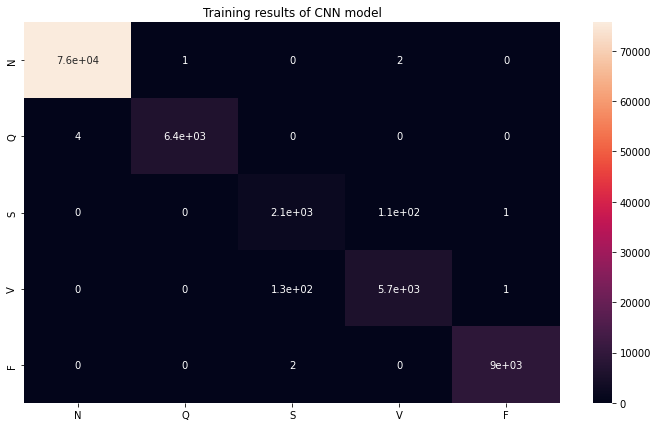

In [21]:

plt.figure(figsize = (12,7))
sns.heatmap(classes_confusion_matrix.cpu().numpy()[-1], annot=True, xticklabels=classes, yticklabels=classes).set(title='Training results of CNN model')


<Figure size 864x504 with 0 Axes>

Text(0.5, 1.0, 'Training Loss')

<Figure size 864x504 with 0 Axes>

Text(0.5, 1.0, 'Training Accuracy')

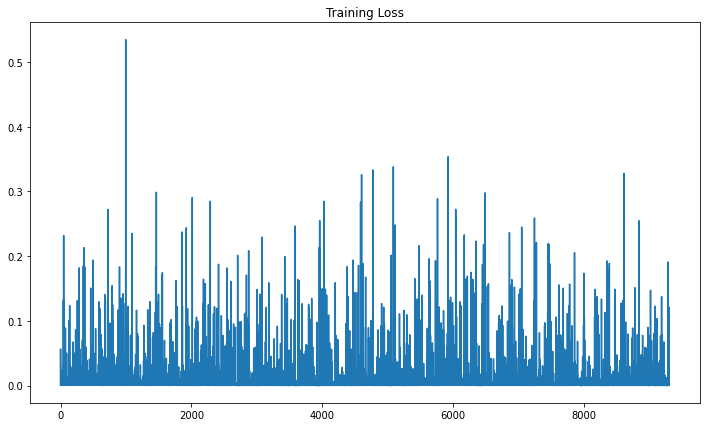

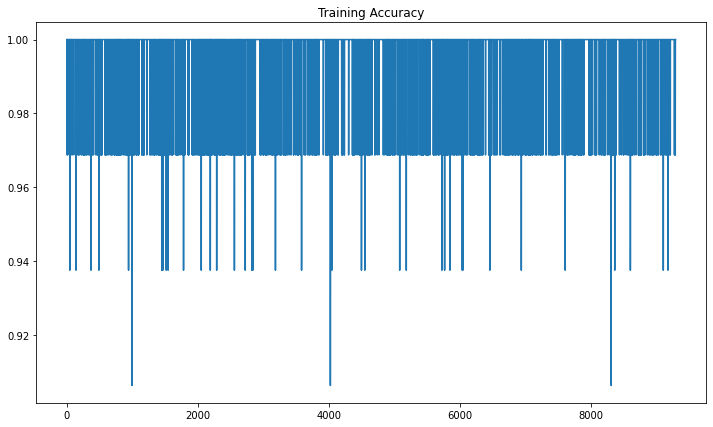

In [28]:
plt.figure(figsize = (12,7))
plt.plot(loss_list);
plt.title("Training Loss")
plt.figure(figsize = (12,7))
plt.plot(accuracies_list)
plt.title("Training Accuracy")
plt.show()

In [29]:
test_confusion_matrix = torch.zeros([5, 5], dtype=torch.int32, device=device)

with torch.no_grad():
    
    for data in test_data_loader:
        
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        labels = [x.item()-1 if x > 0 else x for x in labels]
        labels = torch.tensor(labels)
        labels =  labels.to(device)

        outputs = CNNMODEL(inputs)
        
        _, pred = torch.max(outputs.data, 1)
        
        total = labels.size(0)

        correct_predictions = (pred == labels).sum().item()
        
        for element in range(total):
            test_confusion_matrix[pred[element].item()-1][labels[element].item()-1] += 1

    print(test_confusion_matrix)

tensor([[18922,     0,     0,     0,     0],
        [    2,  1608,     0,     0,     0],
        [    2,     0,   523,    31,     0],
        [    0,     0,    32,  1415,     1],
        [    0,     0,     1,     1,  2261]], device='cuda:0',
       dtype=torch.int32)


In [31]:
matrix_arr = test_confusion_matrix.cpu().numpy()
for i,class_label in enumerate(classes):
  print(f'Prediciton accuracy for class {class_label} : {(matrix_arr[i][i]*100)/sum(matrix_arr[i])}%')

Prediciton accuracy for class N : 100.0%
Prediciton accuracy for class Q : 99.87577639751552%
Prediciton accuracy for class S : 94.06474820143885%
Prediciton accuracy for class V : 97.72099447513813%
Prediciton accuracy for class F : 99.9116217410517%


<Figure size 864x504 with 0 Axes>

[Text(0.5, 1.0, 'Test results of CNN model')]

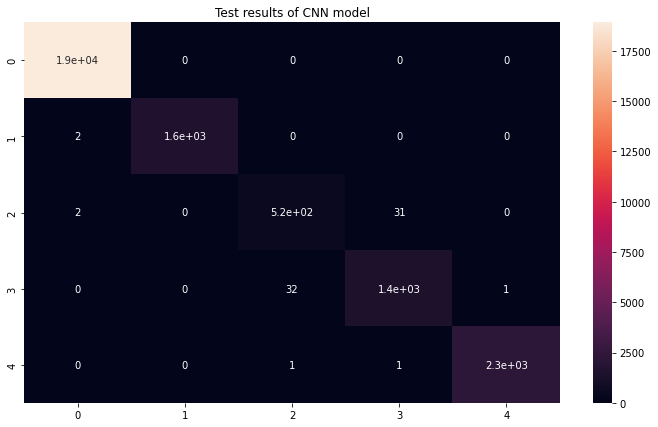

In [34]:

df_cm = pd.DataFrame(test_confusion_matrix.cpu().numpy())
plt.figure(figsize = (12,7))
sns.heatmap(df_cm, annot=True).set(title='Test results of CNN model')
